df_bo columns: ['seed', 'temperature_kelvin', 'pressure_bar', 'label', 'n_candidates', 'init_strategy', 'n_initial', 'initial_structures', 'max_iter', 'patience', 'global_best', 'acq', 'run_id', 'method', 'acq_param_last', 'iters_done', 'stopped_early', 'final_best', 'ratio_to_optimum', 'found_global_best', 'state', 'strategy']
strategies in df_bo: strategy
bo_ucb    60
bo_ei     60
random    60
Name: count, dtype: int64
strategies in df_hist: strategy
bo_ucb    1870
random     852
Name: count, dtype: int64
states in df_bo: ['T=298K,p=1bar', 'T=348K,p=1bar', 'T=400K,p=1bar']
states requested: ['T=298K,p=1bar', 'T=348K,p=1bar', 'T=400K,p=1bar']


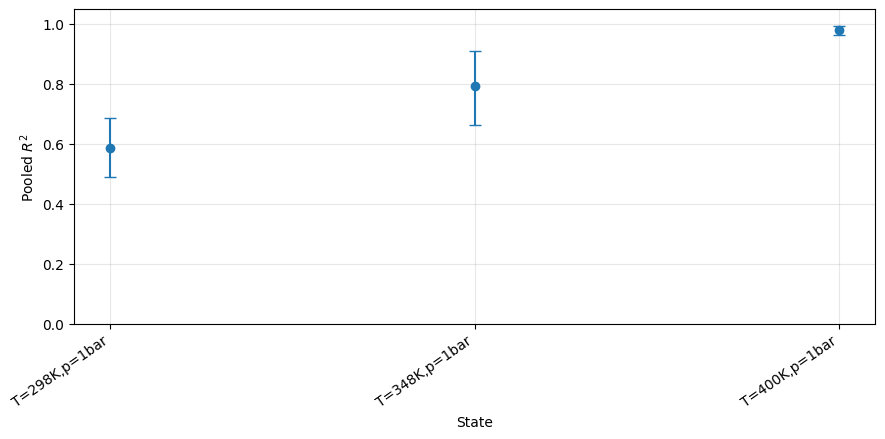

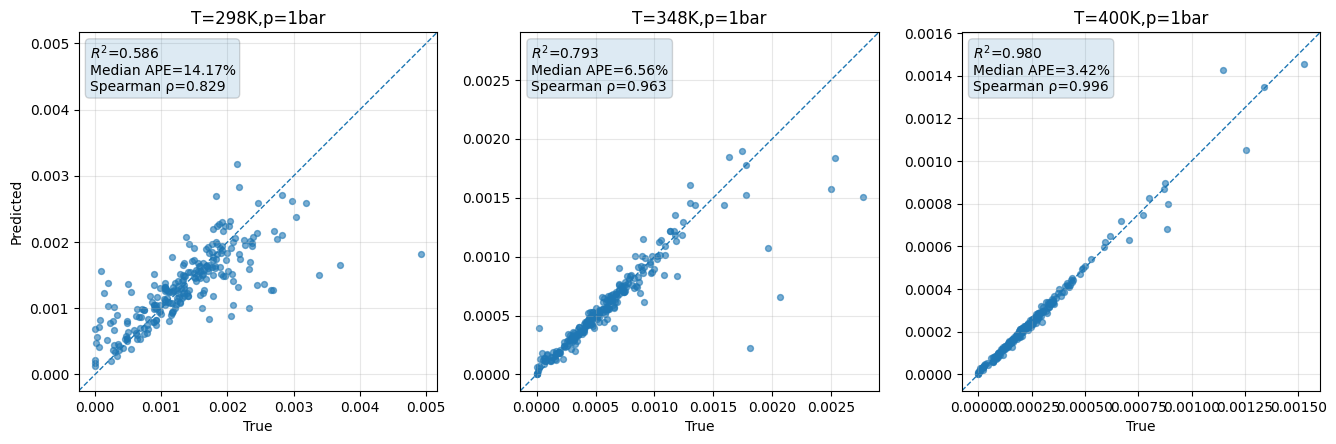

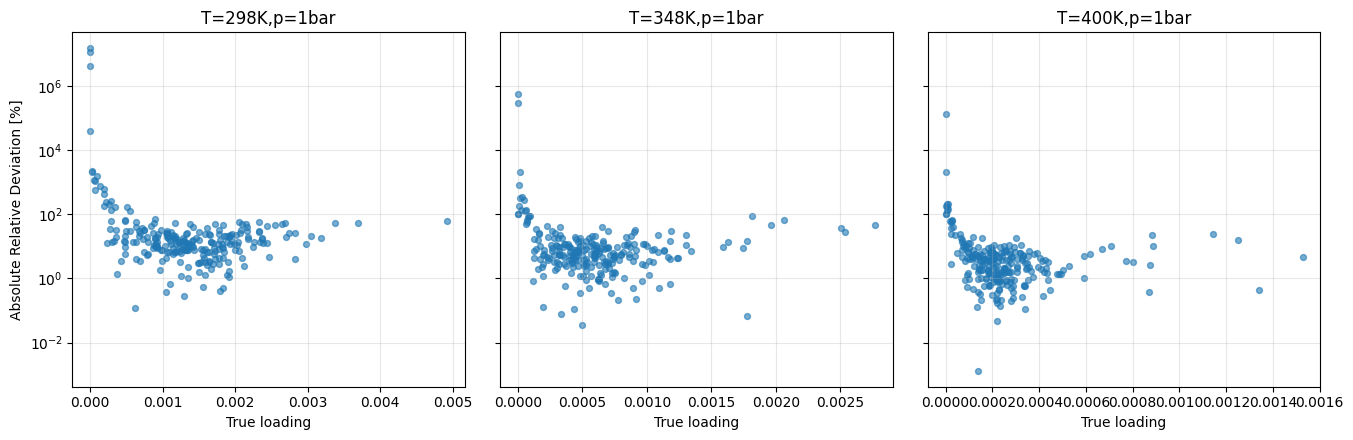

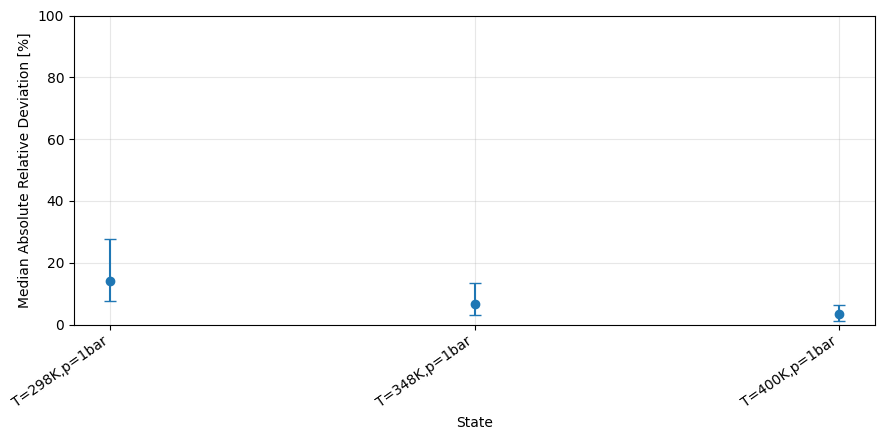

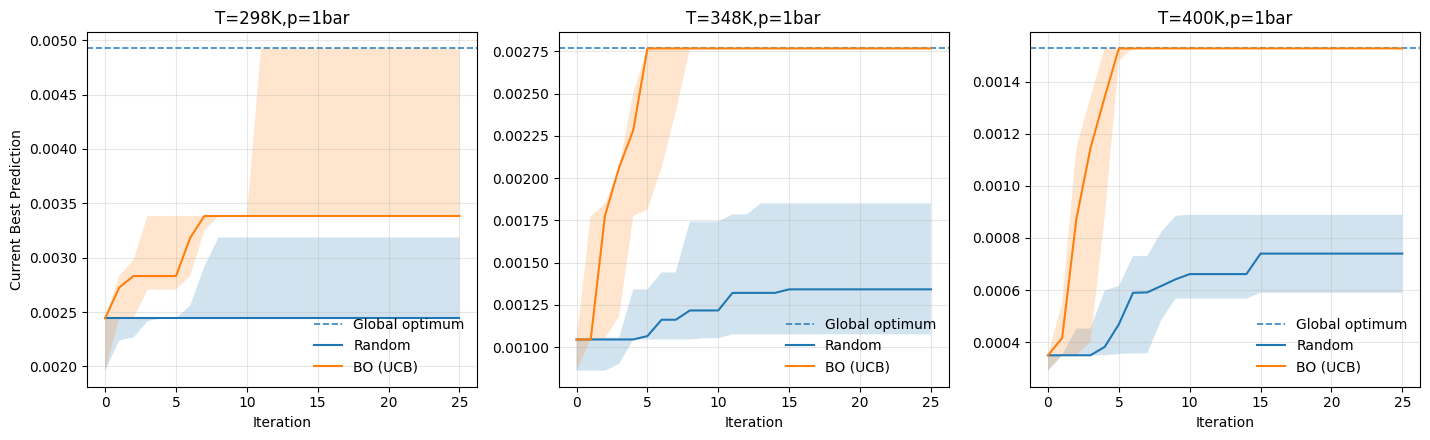

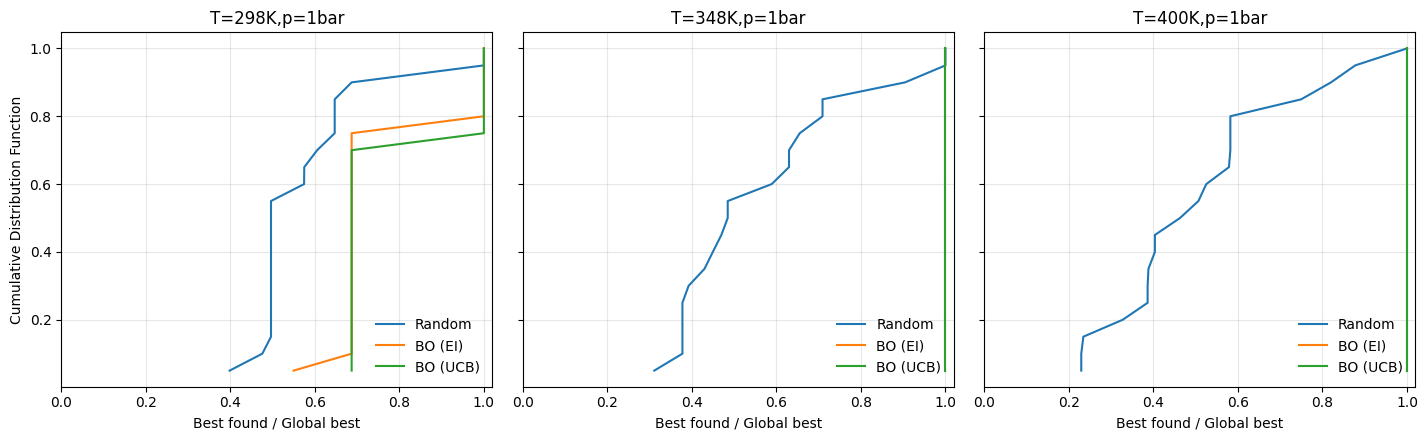

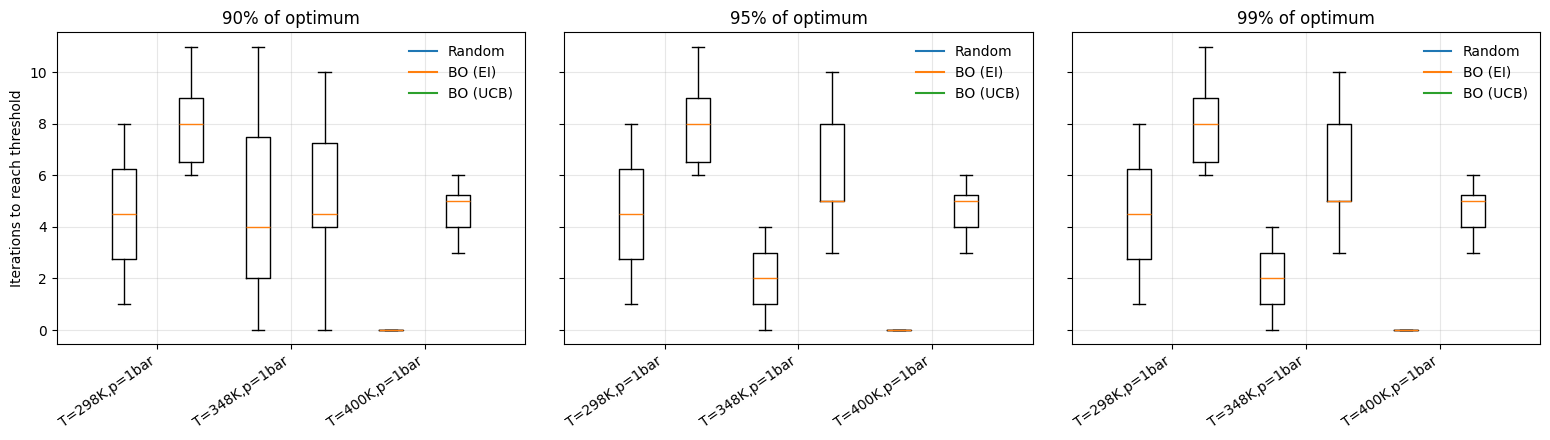

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr

# ----------------------------
# CONFIG  (vary TEMPERATURE at fixed PRESSURE)
# ----------------------------
BASE = Path("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv")

TEMPS = [298, 348, 400]   # <- set the temperatures you want to test
PRESSURE = 1.0            # <- fixed pressure (bar)
LABEL = "beladung_pro_vol"

POOLED_LOG = BASE / "gp_pooled_r2_log_nodens_ucb_40fresh_vol_new_1bar_fresh.csv"
BO_RESULTS  = BASE / "bo_random_results_nodens_ucb_40fresh_vol_new_1bar_fresh.csv"
BO_HISTORY  = BASE / "bo_random_history_nodens_ucb_40fresh_vol_new_1bar_fresh.csv"

# ----------------------------
# Helpers
# ----------------------------
def state_label(t, p):
    return f"T={float(t):.0f}K,p={float(p):g}bar"

def load_oof(t, p):
    f = BASE / f"oof_T{t}_p{p:g}.csv"
    df = pd.read_csv(f)
    df["temperature_kelvin"] = float(t)
    df["pressure_bar"] = float(p)
    df["state"] = state_label(t, p)
    return df

states = [state_label(t, PRESSURE) for t in TEMPS]

def ensure_temp_pressure_and_state(df):
    df = df.copy()
    if "temperature_kelvin" not in df.columns or "pressure_bar" not in df.columns:
        raise ValueError("DataFrame needs columns: 'temperature_kelvin' and 'pressure_bar'")

    df["temperature_kelvin"] = pd.to_numeric(df["temperature_kelvin"], errors="coerce")
    df["pressure_bar"] = pd.to_numeric(df["pressure_bar"], errors="coerce")
    df["state"] = df.apply(lambda r: state_label(r["temperature_kelvin"], r["pressure_bar"]), axis=1)
    df["state"] = df["state"].astype(str).str.strip()
    return df

def ensure_method(df, default="bo"):
    df = df.copy()
    if "method" not in df.columns:
        df["method"] = default

    df["method"] = df["method"].astype(str).str.strip().str.lower()
    df.loc[df["method"].isin(["bayes", "bayesian", "ucb", "ei"]), "method"] = "bo"
    df.loc[df["method"].isin(["rand", "random", "uniform"]), "method"] = "random"
    return df

def ensure_acq(df, default_for_bo="ucb"):
    df = df.copy()
    if "acq" not in df.columns:
        df["acq"] = np.nan

    df = ensure_method(df)

    df["acq"] = df["acq"].astype(str).str.strip().str.lower()
    df.loc[df["acq"].isin(["nan", "none", "null", ""]), "acq"] = np.nan

    df.loc[df["method"] == "random", "acq"] = "none"
    df.loc[(df["method"] == "bo") & (df["acq"].isna()), "acq"] = default_for_bo

    df.loc[df["acq"].isin(["expectedimprovement", "exp_imp"]), "acq"] = "ei"
    df.loc[df["acq"].isin(["upperconfidencebound", "upper_confidence_bound"]), "acq"] = "ucb"
    return df

def add_strategy(df):
    df = df.copy()
    df = ensure_method(df)
    df = ensure_acq(df)
    df["strategy"] = np.where(df["method"] == "random", "random", "bo_" + df["acq"].astype(str))
    return df

# ----------------------------
# RANDOM DEDUPE HELPERS
# ----------------------------
def random_dedupe_key_cols(df):
    """
    Choose strongest available key columns for identifying the same Random run.
    Prefer: state+seed+init_strategy+n_initial+initial_structures
    Fallbacks if some cols are missing.
    """
    candidates = [
        ["state", "seed", "init_strategy", "n_initial", "initial_structures"],
        ["state", "seed", "n_initial", "initial_structures"],
        ["state", "seed", "init_strategy", "n_initial"],
        ["state", "seed"],
    ]
    cols = df.columns.tolist()
    for k in candidates:
        if all(c in cols for c in k):
            return k
    return ["state", "seed"]

def dedupe_random_results(df_bo):
    """
    Keep only one Random row per (state, seed, init-set).
    Prefer the one with largest iters_done (full budget), fallback to first.
    """
    df_bo = df_bo.copy()
    df_bo = ensure_temp_pressure_and_state(df_bo)
    df_bo = add_strategy(df_bo)

    key_cols = random_dedupe_key_cols(df_bo)

    df_random = df_bo[df_bo["method"] == "random"].copy()
    df_other  = df_bo[df_bo["method"] != "random"].copy()

    if len(df_random) == 0:
        return df_bo

    # choose by max iters_done if available, else by run_id if available
    if "iters_done" in df_random.columns:
        df_random["iters_done"] = pd.to_numeric(df_random["iters_done"], errors="coerce")
        df_random = df_random.sort_values(key_cols + ["iters_done"], ascending=[True]*len(key_cols) + [False])
    elif "run_id" in df_random.columns:
        df_random = df_random.sort_values(key_cols + ["run_id"])
    else:
        df_random = df_random.sort_values(key_cols)

    df_random = df_random.drop_duplicates(subset=key_cols, keep="first")
    return pd.concat([df_other, df_random], ignore_index=True)

def dedupe_random_history(df_hist):
    """
    Keep only one Random trajectory per (state, seed, init-set).
    We keep the run_id whose trajectory reaches the largest max(iter).
    """
    df_hist = df_hist.copy()
    df_hist = ensure_temp_pressure_and_state(df_hist)
    df_hist = add_strategy(df_hist)

    key_cols = random_dedupe_key_cols(df_hist)

    h_random = df_hist[df_hist["method"] == "random"].copy()
    h_other  = df_hist[df_hist["method"] != "random"].copy()

    if len(h_random) == 0:
        return df_hist

    # Need run_id to identify trajectories; if missing, just drop duplicates of rows.
    if "run_id" not in h_random.columns:
        h_random = h_random.drop_duplicates(subset=key_cols + ["iter"], keep="first")
        return pd.concat([h_other, h_random], ignore_index=True)

    h_random["iter"] = pd.to_numeric(h_random["iter"], errors="coerce")

    # pick best run_id per key_cols by highest max(iter)
    last_iter = (
        h_random.groupby(key_cols + ["run_id"], dropna=False)["iter"]
        .max()
        .reset_index()
        .rename(columns={"iter": "max_iter"})
    )

    keep = (
        last_iter.sort_values(key_cols + ["max_iter"], ascending=[True]*len(key_cols) + [False])
        .drop_duplicates(subset=key_cols, keep="first")
    )

    h_random = h_random.merge(keep[key_cols + ["run_id"]], on=key_cols + ["run_id"], how="inner")
    return pd.concat([h_other, h_random], ignore_index=True)

# ----------------------------
# POOLED LOG DEDUPE (fix duplicate states -> reindex error)
# ----------------------------
def dedupe_pooled_log(df_r2):
    """
    gp_pooled_r2_log is usually append-mode -> duplicates per state.
    Keep the last occurrence per (state,label) after filtering to fixed PRESSURE.
    """
    d = ensure_temp_pressure_and_state(df_r2)

    # fixed pressure
    d = d[d["pressure_bar"] == float(PRESSURE)].copy()

    # label filter if present
    if "label" in d.columns:
        d = d[d["label"].astype(str).str.strip() == str(LABEL)].copy()

    # keep last per state (and label if present)
    subset = ["state"]
    if "label" in d.columns:
        subset = ["state", "label"]

    d = d.drop_duplicates(subset=subset, keep="last")
    return d

# ----------------------------
# Load data
# ----------------------------
df_r2   = pd.read_csv(POOLED_LOG)
df_bo   = pd.read_csv(BO_RESULTS)
df_hist = pd.read_csv(BO_HISTORY)

# label filters if present
if "label" in df_r2.columns:
    df_r2 = df_r2[df_r2["label"] == LABEL].copy()
if "label" in df_bo.columns:
    df_bo = df_bo[df_bo["label"] == LABEL].copy()
if "label" in df_hist.columns:
    df_hist = df_hist[df_hist["label"] == LABEL].copy()

# normalize: always generate state from numeric columns
df_r2   = ensure_temp_pressure_and_state(df_r2)
df_bo   = add_strategy(ensure_temp_pressure_and_state(df_bo))
df_hist = add_strategy(ensure_temp_pressure_and_state(df_hist))

# fix columns in history
if "iter" not in df_hist.columns:
    for cand in ["iteration", "step"]:
        if cand in df_hist.columns:
            df_hist = df_hist.rename(columns={cand: "iter"})
            break
if "best_so_far" not in df_hist.columns:
    for cand in ["best", "best_value", "best_sofar"]:
        if cand in df_hist.columns:
            df_hist = df_hist.rename(columns={cand: "best_so_far"})
            break

df_hist["iter"] = pd.to_numeric(df_hist["iter"], errors="coerce")
df_hist["best_so_far"] = pd.to_numeric(df_hist["best_so_far"], errors="coerce")

# ----------------------------
# DEDUPE RANDOM (keep only one random per seed+state+init-set)
# ----------------------------
df_bo   = dedupe_random_results(df_bo)
df_hist = dedupe_random_history(df_hist)

# ----------------------------
# DEDUPE pooled log (fix duplicate state labels -> reindex error)
# ----------------------------
df_r2_plot = dedupe_pooled_log(df_r2)

# ----------------------------
# load OOFs (vary temperature at fixed pressure)
# ----------------------------
oof_all = pd.concat([load_oof(t, PRESSURE) for t in TEMPS], ignore_index=True)

if "abs_rel_deviation" not in oof_all.columns:
    oof_all["abs_rel_deviation"] = np.abs((oof_all[LABEL] - oof_all[f"{LABEL}_pred"]) / oof_all[LABEL]) * 100

# --- optional debug ---
print("df_bo columns:", df_bo.columns.tolist())
print("strategies in df_bo:", df_bo["strategy"].value_counts(dropna=False))
print("strategies in df_hist:", df_hist["strategy"].value_counts(dropna=False))
print("states in df_bo:", sorted(df_bo["state"].unique().tolist()))
print("states requested:", states)

# ============================================================
# PLOT 1: pooled R² + CI per state
# ============================================================
def plot_pooled_r2_ci(df_r2_in, outfile=BASE/"01_pooled_r2_ci_varyT_nodens_40fresh_vol.png"):
    d = ensure_temp_pressure_and_state(df_r2_in)
    d = d[d["pressure_bar"] == float(PRESSURE)].copy()
    if "label" in d.columns:
        d = d[d["label"].astype(str).str.strip() == str(LABEL)].copy()

    # FIX: ensure unique state index
    d = d.drop_duplicates(subset=["state"], keep="last")

    d = d.set_index("state").reindex(states).reset_index()

    x = np.arange(len(d))
    y = pd.to_numeric(d["pooled_r2"], errors="coerce").to_numpy()
    low = pd.to_numeric(d["ci95_low"], errors="coerce").to_numpy()
    high = pd.to_numeric(d["ci95_high"], errors="coerce").to_numpy()
    yerr = np.vstack([y - low, high - y])

    plt.figure(figsize=(9, 4.5))
    plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
    plt.xticks(x, d["state"], rotation=35, ha="right")
    plt.ylabel("Pooled $R^2$")
    plt.xlabel("State")
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 2: Parity plots (per state)
# ============================================================
def plot_parity_panels(oof_all, outfile=BASE/"02_parity_panels_varyT_nodens_40fresh_vol.png"):
    fig, axs = plt.subplots(1, len(states), figsize=(4.5 * len(states), 4.5))
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        df = oof_all[oof_all["state"] == st].copy()
        if df.empty:
            ax.set_title(f"{st}\n(no data)")
            ax.axis("off")
            continue

        y_true = df[LABEL].to_numpy()
        y_pred = df[f"{LABEL}_pred"].to_numpy()

        mn = min(np.nanmin(y_true), np.nanmin(y_pred))
        mx = max(np.nanmax(y_true), np.nanmax(y_pred))
        span = mx - mn
        pad = 0.05 * span if span > 0 else 1e-6
        lo = mn - pad
        hi = mx + pad

        ax.scatter(y_true, y_pred, s=18, alpha=0.6)
        ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1)

        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)
        ax.set_aspect("equal", adjustable="box")

        denom = np.sum((y_true - y_true.mean()) ** 2)
        r2 = 1 - np.sum((y_true - y_pred) ** 2) / denom if denom != 0 else np.nan
        mdape = np.nanmedian(df["abs_rel_deviation"].to_numpy())
        rho, _ = spearmanr(y_true, y_pred)

        ax.set_title(st)
        ax.set_xlabel("True")
        ax.grid(alpha=0.3)

        ax.text(
            0.03, 0.97,
            f"$R^2$={r2:.3f}\nMedian APE={mdape:.2f}%\nSpearman ρ={rho:.3f}",
            transform=ax.transAxes,
            va="top", ha="left",
            fontsize=10,
            bbox=dict(boxstyle="round", alpha=0.15)
        )

    axs[0].set_ylabel("Predicted")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 3A: ARD scatter log-y
# ============================================================
def plot_ard_scatter_logy(oof_all, outfile=BASE/"03a_ard_scatter_logy_varyT_nodens_40fresh_vol.png"):
    fig, axs = plt.subplots(1, len(states), figsize=(4.5 * len(states), 4.5), sharey=True)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        df = oof_all[oof_all["state"] == st].copy()
        if df.empty:
            ax.set_title(f"{st}\n(no data)")
            ax.axis("off")
            continue

        ax.scatter(df[LABEL], df["abs_rel_deviation"], s=18, alpha=0.6)
        ax.set_title(st)
        ax.set_xlabel("True loading")
        ax.set_yscale("log")
        ax.grid(alpha=0.3)

    axs[0].set_ylabel("Absolute Relative Deviation [%]")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 3B: Median + IQR ARD per state
# ============================================================
def plot_ard_median_iqr(oof_all, outfile=BASE/"03b_ard_median_iqr_varyT_nodens_40fresh_vol.png"):
    rows = []
    for st in states:
        df = oof_all[oof_all["state"] == st]
        if df.empty:
            rows.append((st, np.nan, np.nan, np.nan))
            continue
        med = df["abs_rel_deviation"].median()
        q25 = df["abs_rel_deviation"].quantile(0.25)
        q75 = df["abs_rel_deviation"].quantile(0.75)
        rows.append((st, med, q25, q75))

    d = pd.DataFrame(rows, columns=["state", "median", "q25", "q75"])
    x = np.arange(len(d))

    y = d["median"].to_numpy()
    yerr = np.vstack([y - d["q25"].to_numpy(), d["q75"].to_numpy() - y])

    plt.figure(figsize=(9, 4.5))
    plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
    plt.xticks(x, d["state"], rotation=35, ha="right")
    plt.ylabel("Median Absolute Relative Deviation [%]")
    plt.xlabel("State")
    plt.ylim(0, 100)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 4: Best-so-far vs Iteration (Random vs BO(EI) vs BO(UCB)) + global optimum line
# ============================================================
def plot_best_so_far_curves(df_hist, df_bo, states,
                            outfile=BASE/"04_best_so_far_random_ei_ucb_varyT_nodens_40fresh_vol.png"):
    dh = add_strategy(ensure_temp_pressure_and_state(df_hist))
    db = add_strategy(ensure_temp_pressure_and_state(df_bo))

    req_h = {"run_id", "iter", "best_so_far", "strategy", "temperature_kelvin", "pressure_bar"}
    miss_h = req_h.difference(dh.columns)
    if miss_h:
        raise ValueError(f"df_hist missing columns: {miss_h}")

    req_b = {"global_best", "state"}
    miss_b = req_b.difference(db.columns)
    if miss_b:
        raise ValueError(f"df_bo missing columns: {miss_b}")

    dh["iter"] = pd.to_numeric(dh["iter"], errors="coerce")
    dh["best_so_far"] = pd.to_numeric(dh["best_so_far"], errors="coerce")
    db["global_best"] = pd.to_numeric(db["global_best"], errors="coerce")

    dh = dh[dh["state"].isin(states)].dropna(subset=["iter", "best_so_far"]).copy()
    db = db[db["state"].isin(states)].dropna(subset=["global_best"]).copy()

    if dh.empty:
        print("No history rows found for the selected states.")
        return

    gb = db.groupby("state")["global_best"].median().to_dict()

    max_iter_val = dh["iter"].max()
    if pd.isna(max_iter_val):
        print("History 'iter' is all NaN after filtering.")
        return
    max_iter = int(max_iter_val)

    fig, axs = plt.subplots(1, len(states), figsize=(4.8 * len(states), 4.5), sharey=False)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        sub = dh[dh["state"] == st].copy()

        if st in gb and np.isfinite(gb[st]):
            ax.axhline(gb[st], linestyle="--", linewidth=1.2, alpha=0.9, label="Global optimum")

        for strat, pretty in [("random", "Random"), ("bo_ei", "BO (EI)"), ("bo_ucb", "BO (UCB)")]:
            m = sub[sub["strategy"] == strat].copy()
            if m.empty:
                continue

            piv = m.pivot_table(index="iter", columns="run_id", values="best_so_far", aggfunc="first")
            piv = piv.reindex(range(max_iter + 1)).ffill()

            median = piv.median(axis=1).to_numpy()
            q25 = piv.quantile(0.25, axis=1).to_numpy()
            q75 = piv.quantile(0.75, axis=1).to_numpy()

            ax.plot(np.arange(max_iter + 1), median, label=pretty)
            ax.fill_between(np.arange(max_iter + 1), q25, q75, alpha=0.2)

        ax.set_title(st)
        ax.set_xlabel("Iteration")
        ax.grid(alpha=0.3)

        handles, labels = ax.get_legend_handles_labels()
        uniq = dict(zip(labels, handles))
        ax.legend(uniq.values(), uniq.keys(), frameon=False, loc="lower right")

    axs[0].set_ylabel("Current Best Prediction")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 5: CDF of ratio_to_optimum (Random vs BO(EI) vs BO(UCB)) per state
# ============================================================
def plot_ratio_cdf(df_bo, states, outfile=BASE/"05_ratio_cdf_random_ei_ucb_varyT_nodens_40fresh_vol.png"):
    db = add_strategy(ensure_temp_pressure_and_state(df_bo))

    required = {"strategy", "ratio_to_optimum", "temperature_kelvin", "pressure_bar", "state"}
    missing = required.difference(db.columns)
    if missing:
        raise ValueError(f"df_bo missing columns: {missing}")

    db = db[db["state"].isin(states)].copy()
    if db.empty:
        print("No result rows found for selected states.")
        return

    fig, axs = plt.subplots(1, len(states), figsize=(4.8 * len(states), 4.5), sharey=True)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        sub = db[db["state"] == st].copy()

        for strat, pretty in [("random", "Random"), ("bo_ei", "BO (EI)"), ("bo_ucb", "BO (UCB)")]:
            vals = sub[sub["strategy"] == strat]["ratio_to_optimum"].dropna().to_numpy()
            if len(vals) == 0:
                continue
            vals = np.sort(vals)
            y = np.arange(1, len(vals) + 1) / len(vals)
            ax.plot(vals, y, label=pretty)

        ax.set_title(st)
        ax.set_xlabel("Best found / Global best")
        ax.set_xlim(0, 1.02)
        ax.grid(alpha=0.3)
        ax.legend(frameon=False, loc="lower right")

    axs[0].set_ylabel("Cumulative Distribution Function")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 6: Time-to-threshold (Random vs BO(EI) vs BO(UCB))
# ============================================================
def plot_time_to_threshold(df_hist, df_bo, states, thresholds=(0.90, 0.95, 0.99),
                           outfile=BASE/"06_time_to_threshold_random_ei_ucb_varyT_nodens_40fresh_vol.png"):
    dh = add_strategy(ensure_temp_pressure_and_state(df_hist))
    db = add_strategy(ensure_temp_pressure_and_state(df_bo))

    req_h = {"run_id", "iter", "best_so_far", "state", "strategy"}
    req_b = {"state", "global_best"}
    if req_h.difference(dh.columns):
        raise ValueError(f"df_hist missing columns: {req_h.difference(dh.columns)}")
    if req_b.difference(db.columns):
        raise ValueError(f"df_bo missing columns: {req_b.difference(db.columns)}")

    dh["iter"] = pd.to_numeric(dh["iter"], errors="coerce")
    dh["best_so_far"] = pd.to_numeric(dh["best_so_far"], errors="coerce")
    db["global_best"] = pd.to_numeric(db["global_best"], errors="coerce")

    dh = dh[dh["state"].isin(states)].dropna(subset=["iter", "best_so_far"]).copy()
    db = db[db["state"].isin(states)].dropna(subset=["global_best"]).copy()

    if dh.empty or db.empty:
        print("No data for time-to-threshold after filtering.")
        return

    gb = db.groupby("state")["global_best"].median().to_dict()

    rows = []
    for st in states:
        if st not in gb or gb[st] == 0 or np.isnan(gb[st]):
            continue
        gbest = gb[st]
        sub = dh[dh["state"] == st].copy()

        for strat in ["random", "bo_ei", "bo_ucb"]:
            m = sub[sub["strategy"] == strat].copy()
            if m.empty:
                continue

            for run_id, grp in m.groupby("run_id"):
                grp = grp.sort_values("iter")
                for thr in thresholds:
                    target = thr * gbest
                    hit = grp[grp["best_so_far"] >= target]
                    it = float(hit["iter"].iloc[0]) if len(hit) else np.nan
                    rows.append({"state": st, "strategy": strat, "threshold": thr, "iters_to_thr": it})

    d = pd.DataFrame(rows).dropna(subset=["iters_to_thr"])
    if d.empty:
        print("No threshold hits found.")
        return

    fig, axs = plt.subplots(1, len(thresholds), figsize=(5.2 * len(thresholds), 4.5), sharey=True)
    if len(thresholds) == 1:
        axs = [axs]

    for ax, thr in zip(axs, thresholds):
        sub = d[d["threshold"] == thr]

        x = np.arange(len(states))
        w = 0.25

        data_random = [sub[(sub["state"] == st) & (sub["strategy"] == "random")]["iters_to_thr"].to_numpy() for st in states]
        data_ei     = [sub[(sub["state"] == st) & (sub["strategy"] == "bo_ei")]["iters_to_thr"].to_numpy() for st in states]
        data_ucb    = [sub[(sub["state"] == st) & (sub["strategy"] == "bo_ucb")]["iters_to_thr"].to_numpy() for st in states]

        ax.boxplot(data_random, positions=x - w, widths=0.18, showfliers=False)
        ax.boxplot(data_ei,     positions=x,     widths=0.18, showfliers=False)
        ax.boxplot(data_ucb,    positions=x + w, widths=0.18, showfliers=False)

        ax.set_xticks(x)
        ax.set_xticklabels(states, rotation=35, ha="right")
        ax.set_title(f"{int(thr*100)}% of optimum")
        ax.grid(alpha=0.3)

        ax.plot([], [], label="Random")
        ax.plot([], [], label="BO (EI)")
        ax.plot([], [], label="BO (UCB)")
        ax.legend(frameon=False, loc="upper right")

    axs[0].set_ylabel("Iterations to reach threshold")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# RUN PLOTS
# ============================================================
plot_pooled_r2_ci(df_r2_plot)
plot_parity_panels(oof_all)
plot_ard_scatter_logy(oof_all)
plot_ard_median_iqr(oof_all)
plot_best_so_far_curves(df_hist, df_bo, states)
plot_ratio_cdf(df_bo, states)
plot_time_to_threshold(df_hist, df_bo, states, thresholds=(0.90, 0.95, 0.99))


df_bo columns: ['seed', 'temperature_kelvin', 'pressure_bar', 'label', 'n_candidates', 'init_strategy', 'n_initial', 'initial_structures', 'max_iter', 'patience', 'global_best', 'acq', 'run_id', 'method', 'acq_param_last', 'iters_done', 'stopped_early', 'final_best', 'ratio_to_optimum', 'found_global_best', 'state', 'strategy']
strategies in df_bo: strategy
bo_ucb    60
bo_ei     60
random    60
Name: count, dtype: int64
strategies in df_hist: strategy
bo_ei     983
bo_ucb    887
random    852
Name: count, dtype: int64
states in df_bo: ['T=298K,p=1bar', 'T=348K,p=1bar', 'T=400K,p=1bar']
states requested: ['T=298K,p=1bar', 'T=348K,p=1bar', 'T=400K,p=1bar']


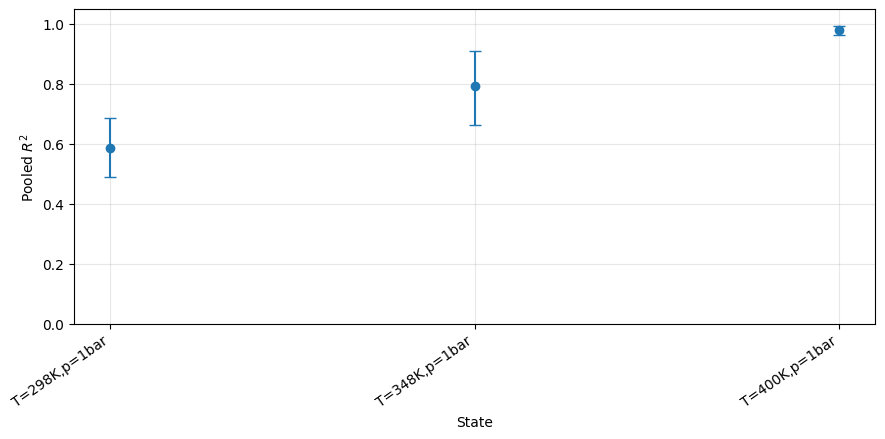

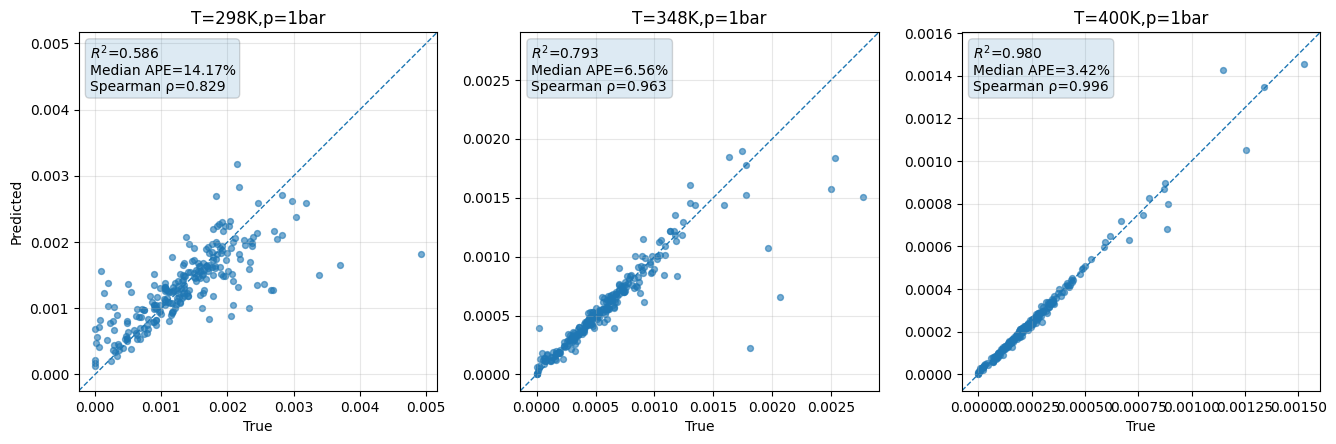

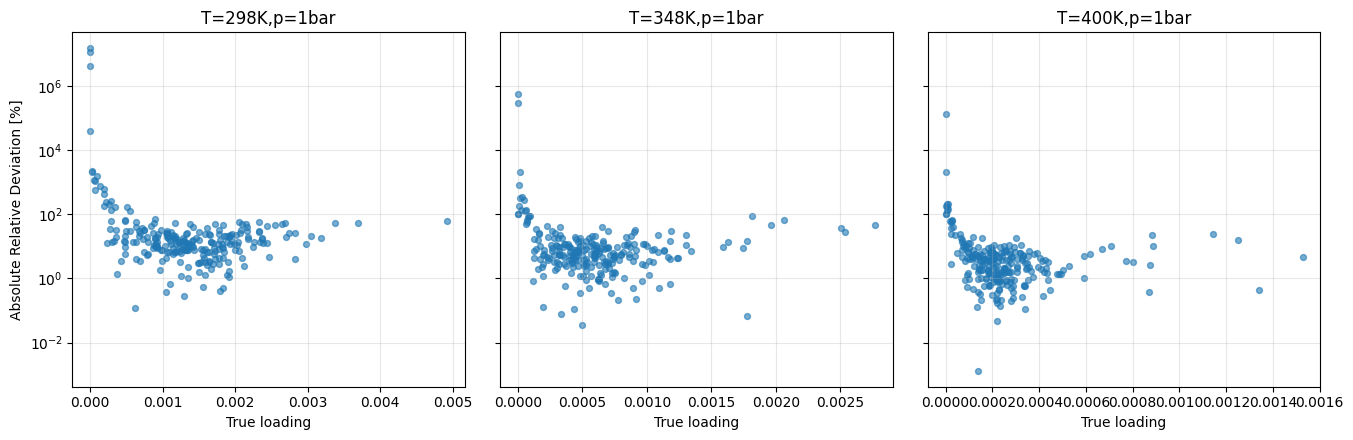

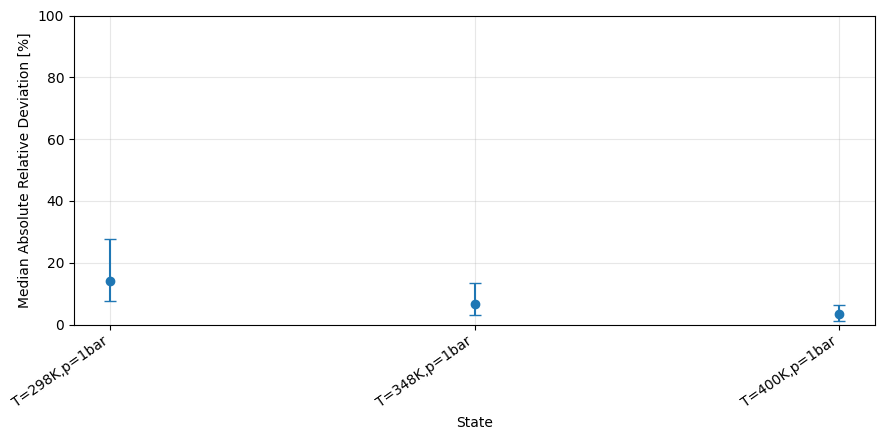

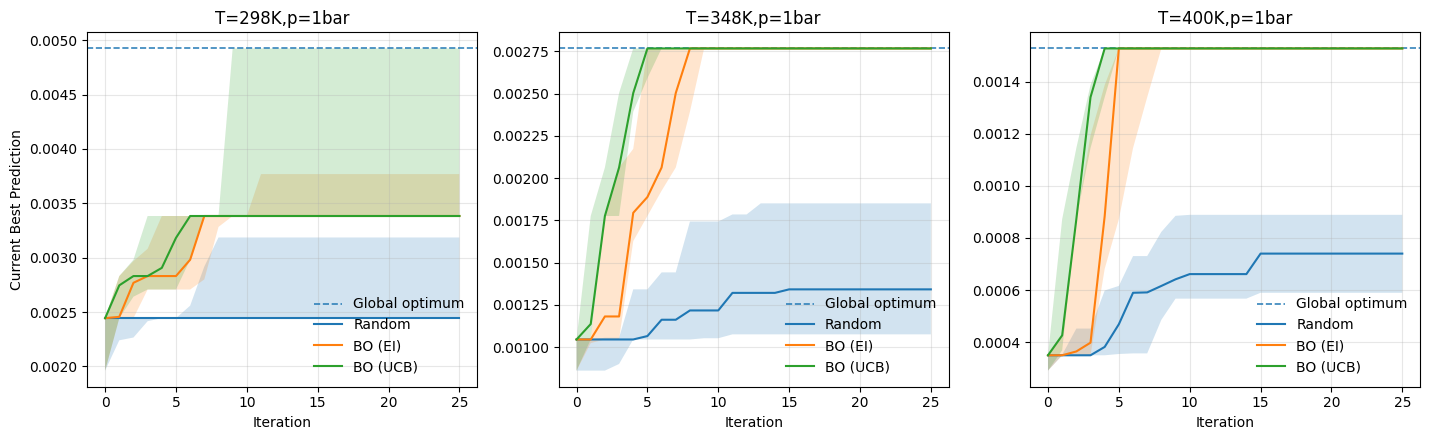

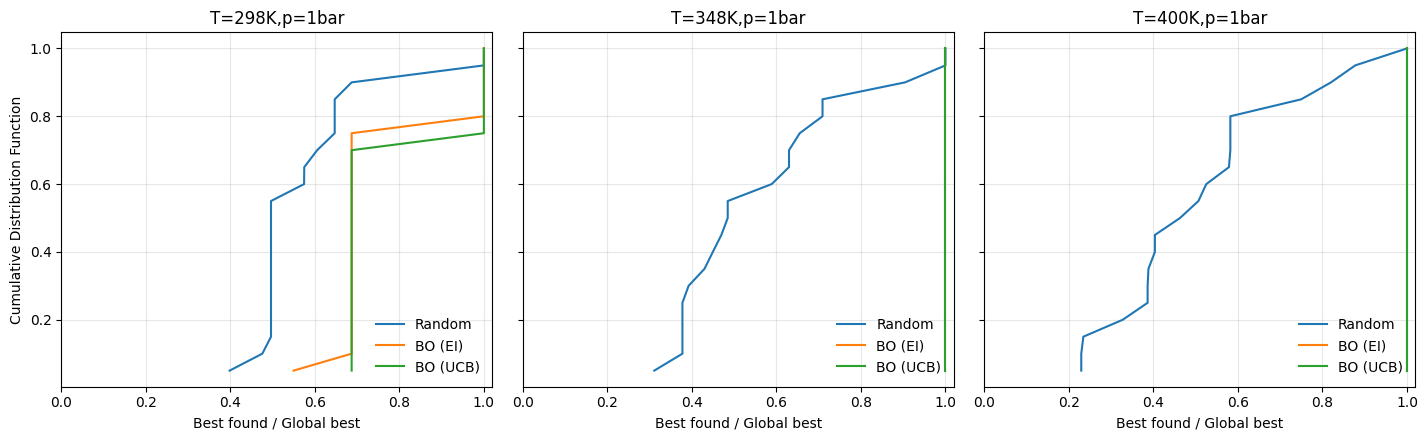

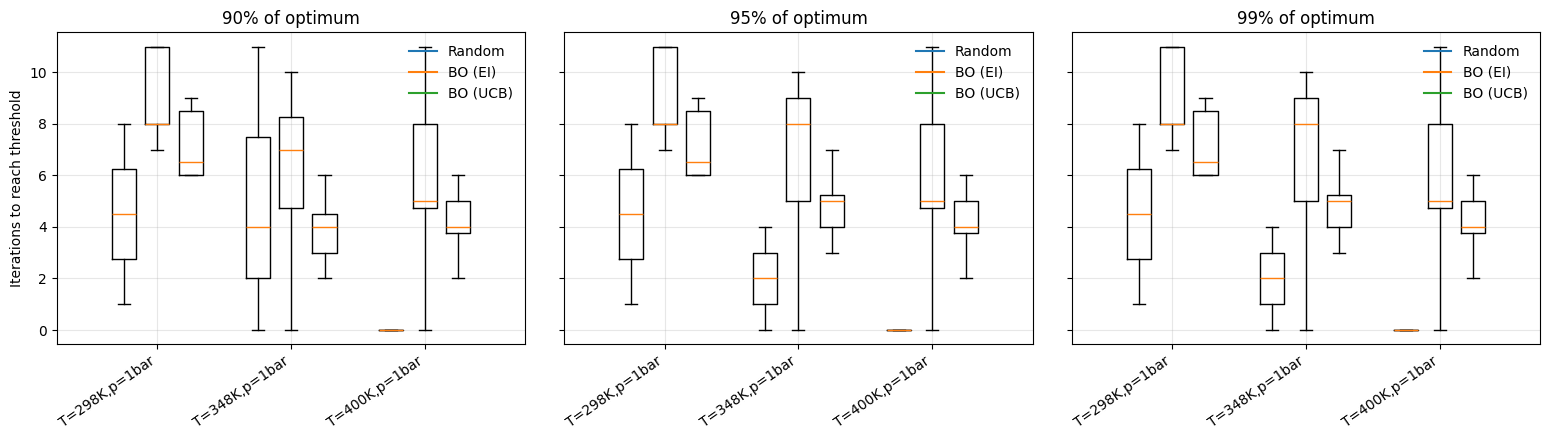

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr

# ----------------------------
# CONFIG  (vary TEMPERATURE at fixed PRESSURE)
# ----------------------------
BASE = Path("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv")

TEMPS = [298, 348, 400]   # <- set the temperatures you want to test
PRESSURE = 1.0            # <- fixed pressure (bar)
LABEL = "beladung_pro_vol"

POOLED_LOG = BASE / "gp_pooled_r2_log_nodens_ucb_40fresh_vol_new_1bar_fresh.csv"
BO_RESULTS  = BASE / "bo_random_results_nodens_ucb_40fresh_vol_new_1bar_fresh.csv"
BO_HISTORY  = BASE / "bo_random_history_nodens_ucb_40fresh_vol_new_1bar_fresh.csv"

# ----------------------------
# Helpers
# ----------------------------
def state_label(t, p):
    return f"T={float(t):.0f}K,p={float(p):g}bar"

def load_oof(t, p):
    f = BASE / f"oof_T{t}_p{p:g}.csv"
    df = pd.read_csv(f)
    df["temperature_kelvin"] = float(t)
    df["pressure_bar"] = float(p)
    df["state"] = state_label(t, p)
    return df

states = [state_label(t, PRESSURE) for t in TEMPS]

def ensure_temp_pressure_and_state(df):
    df = df.copy()
    if "temperature_kelvin" not in df.columns or "pressure_bar" not in df.columns:
        raise ValueError("DataFrame needs columns: 'temperature_kelvin' and 'pressure_bar'")

    df["temperature_kelvin"] = pd.to_numeric(df["temperature_kelvin"], errors="coerce")
    df["pressure_bar"] = pd.to_numeric(df["pressure_bar"], errors="coerce")
    df["state"] = df.apply(lambda r: state_label(r["temperature_kelvin"], r["pressure_bar"]), axis=1)
    df["state"] = df["state"].astype(str).str.strip()
    return df

def ensure_method(df, default="bo"):
    df = df.copy()
    if "method" not in df.columns:
        df["method"] = default

    df["method"] = df["method"].astype(str).str.strip().str.lower()
    df.loc[df["method"].isin(["bayes", "bayesian", "ucb", "ei"]), "method"] = "bo"
    df.loc[df["method"].isin(["rand", "random", "uniform"]), "method"] = "random"
    return df

def ensure_acq(df, default_for_bo=None):
    """
    IMPORTANT:
    - Random gets acq='none'
    - BO keeps its given 'acq'
    - Only fill missing BO acq if default_for_bo is not None
      (so we avoid collapsing EI->UCB when acq is missing in history!)
    """
    df = df.copy()
    if "acq" not in df.columns:
        df["acq"] = np.nan

    df = ensure_method(df)

    df["acq"] = df["acq"].astype(str).str.strip().str.lower()
    df.loc[df["acq"].isin(["nan", "none", "null", ""]), "acq"] = np.nan

    # normalize synonyms
    df.loc[df["acq"].isin(["expectedimprovement", "exp_imp"]), "acq"] = "ei"
    df.loc[df["acq"].isin(["upperconfidencebound", "upper_confidence_bound"]), "acq"] = "ucb"

    # random
    df.loc[df["method"] == "random", "acq"] = "none"

    # BO: only fill if you explicitly want a default
    if default_for_bo is not None:
        df.loc[(df["method"] == "bo") & (df["acq"].isna()), "acq"] = default_for_bo

    return df

def add_strategy(df):
    df = df.copy()
    df = ensure_method(df)
    # NOTE: do NOT default BO-acq here; we want it to stay NaN if missing
    df = ensure_acq(df, default_for_bo=None)

    df["strategy"] = np.where(
        df["method"] == "random",
        "random",
        np.where(df["acq"].isna(), "bo_unknown", "bo_" + df["acq"].astype(str))
    )
    return df

# ----------------------------
# Inject acq into HISTORY using RESULTS (run_id mapping)
# ----------------------------
def inject_acq_into_history(df_hist, df_bo):
    """
    df_bo has reliable run_id -> acq.
    If df_hist has missing/no acq, inject it via run_id.
    """
    h = df_hist.copy()
    b = df_bo.copy()

    h = ensure_method(h)
    b = ensure_acq(ensure_method(b), default_for_bo=None)

    if "run_id" not in h.columns or "run_id" not in b.columns:
        return h

    run_map = (
        b[["run_id", "acq"]]
        .dropna(subset=["run_id"])
        .drop_duplicates(subset=["run_id"], keep="last")
    )

    # ensure h has acq col
    if "acq" not in h.columns:
        h["acq"] = np.nan
    else:
        # normalize empty markers to NaN
        tmp = h["acq"].astype(str).str.strip().str.lower()
        h.loc[tmp.isin(["nan", "none", "null", ""]), "acq"] = np.nan

    h = h.merge(run_map, on="run_id", how="left", suffixes=("", "_from_results"))
    # fill only missing acq in history
    h["acq"] = h["acq"].fillna(h["acq_from_results"])
    h = h.drop(columns=["acq_from_results"])

    return h

# ----------------------------
# RANDOM DEDUPE HELPERS (only for RANDOM; BO stays untouched)
# ----------------------------
def random_dedupe_key_cols(df):
    candidates = [
        ["state", "seed", "init_strategy", "n_initial", "initial_structures"],
        ["state", "seed", "n_initial", "initial_structures"],
        ["state", "seed", "init_strategy", "n_initial"],
        ["state", "seed"],
    ]
    cols = df.columns.tolist()
    for k in candidates:
        if all(c in cols for c in k):
            return k
    return ["state", "seed"]

def dedupe_random_results(df_bo):
    df_bo = df_bo.copy()
    df_bo = ensure_temp_pressure_and_state(df_bo)
    df_bo = add_strategy(df_bo)

    key_cols = random_dedupe_key_cols(df_bo)

    df_random = df_bo[df_bo["method"] == "random"].copy()
    df_other  = df_bo[df_bo["method"] != "random"].copy()

    if len(df_random) == 0:
        return df_bo

    if "iters_done" in df_random.columns:
        df_random["iters_done"] = pd.to_numeric(df_random["iters_done"], errors="coerce")
        df_random = df_random.sort_values(key_cols + ["iters_done"], ascending=[True]*len(key_cols) + [False])
    elif "run_id" in df_random.columns:
        df_random = df_random.sort_values(key_cols + ["run_id"])
    else:
        df_random = df_random.sort_values(key_cols)

    df_random = df_random.drop_duplicates(subset=key_cols, keep="first")
    return pd.concat([df_other, df_random], ignore_index=True)

def dedupe_random_history(df_hist):
    df_hist = df_hist.copy()
    df_hist = ensure_temp_pressure_and_state(df_hist)
    df_hist = add_strategy(df_hist)

    key_cols = random_dedupe_key_cols(df_hist)

    h_random = df_hist[df_hist["method"] == "random"].copy()
    h_other  = df_hist[df_hist["method"] != "random"].copy()

    if len(h_random) == 0:
        return df_hist

    if "run_id" not in h_random.columns:
        h_random = h_random.drop_duplicates(subset=key_cols + ["iter"], keep="first")
        return pd.concat([h_other, h_random], ignore_index=True)

    h_random["iter"] = pd.to_numeric(h_random["iter"], errors="coerce")

    last_iter = (
        h_random.groupby(key_cols + ["run_id"], dropna=False)["iter"]
        .max()
        .reset_index()
        .rename(columns={"iter": "max_iter"})
    )

    keep = (
        last_iter.sort_values(key_cols + ["max_iter"], ascending=[True]*len(key_cols) + [False])
        .drop_duplicates(subset=key_cols, keep="first")
    )

    h_random = h_random.merge(keep[key_cols + ["run_id"]], on=key_cols + ["run_id"], how="inner")
    return pd.concat([h_other, h_random], ignore_index=True)

# ----------------------------
# POOLED LOG DEDUPE (fix duplicate states -> reindex error)
# ----------------------------
def dedupe_pooled_log(df_r2):
    d = ensure_temp_pressure_and_state(df_r2)
    d = d[d["pressure_bar"] == float(PRESSURE)].copy()
    if "label" in d.columns:
        d = d[d["label"].astype(str).str.strip() == str(LABEL)].copy()
    d = d.drop_duplicates(subset=["state"], keep="last")
    return d

# ----------------------------
# Load data
# ----------------------------
df_r2   = pd.read_csv(POOLED_LOG)
df_bo   = pd.read_csv(BO_RESULTS)
df_hist = pd.read_csv(BO_HISTORY)

# label filters if present
if "label" in df_r2.columns:
    df_r2 = df_r2[df_r2["label"] == LABEL].copy()
if "label" in df_bo.columns:
    df_bo = df_bo[df_bo["label"] == LABEL].copy()
if "label" in df_hist.columns:
    df_hist = df_hist[df_hist["label"] == LABEL].copy()

# Normalize minimal columns first
df_r2   = ensure_temp_pressure_and_state(df_r2)
df_bo   = ensure_temp_pressure_and_state(df_bo)
df_hist = ensure_temp_pressure_and_state(df_hist)

# Ensure method in both
df_bo   = ensure_method(df_bo)
df_hist = ensure_method(df_hist)

# Ensure acq in RESULTS (should already be fine)
df_bo = ensure_acq(df_bo, default_for_bo=None)

# ---- CRITICAL FIX: inject acq into HISTORY from RESULTS BEFORE making strategy ----
df_hist = inject_acq_into_history(df_hist, df_bo)

# Now build strategy labels
df_bo   = add_strategy(df_bo)
df_hist = add_strategy(df_hist)

# fix columns in history
if "iter" not in df_hist.columns:
    for cand in ["iteration", "step"]:
        if cand in df_hist.columns:
            df_hist = df_hist.rename(columns={cand: "iter"})
            break
if "best_so_far" not in df_hist.columns:
    for cand in ["best", "best_value", "best_sofar"]:
        if cand in df_hist.columns:
            df_hist = df_hist.rename(columns={cand: "best_so_far"})
            break

df_hist["iter"] = pd.to_numeric(df_hist["iter"], errors="coerce")
df_hist["best_so_far"] = pd.to_numeric(df_hist["best_so_far"], errors="coerce")

# Dedupe RANDOM only
df_bo   = dedupe_random_results(df_bo)
df_hist = dedupe_random_history(df_hist)

# Pooled log dedupe (for plot 1)
df_r2_plot = dedupe_pooled_log(df_r2)

# load OOFs
oof_all = pd.concat([load_oof(t, PRESSURE) for t in TEMPS], ignore_index=True)
if "abs_rel_deviation" not in oof_all.columns:
    oof_all["abs_rel_deviation"] = np.abs((oof_all[LABEL] - oof_all[f"{LABEL}_pred"]) / oof_all[LABEL]) * 100

# --- debug ---
print("df_bo columns:", df_bo.columns.tolist())
print("strategies in df_bo:", df_bo["strategy"].value_counts(dropna=False))
print("strategies in df_hist:", df_hist["strategy"].value_counts(dropna=False))
print("states in df_bo:", sorted(df_bo["state"].unique().tolist()))
print("states requested:", states)

# ============================================================
# PLOT 1: pooled R² + CI per state
# ============================================================
def plot_pooled_r2_ci(df_r2_in, outfile=BASE/"01_pooled_r2_ci_varyT_nodens_40fresh_vol.png"):
    d = ensure_temp_pressure_and_state(df_r2_in)
    d = d[d["pressure_bar"] == float(PRESSURE)].copy()
    if "label" in d.columns:
        d = d[d["label"].astype(str).str.strip() == str(LABEL)].copy()

    d = d.drop_duplicates(subset=["state"], keep="last")
    d = d.set_index("state").reindex(states).reset_index()

    x = np.arange(len(d))
    y = pd.to_numeric(d["pooled_r2"], errors="coerce").to_numpy()
    low = pd.to_numeric(d["ci95_low"], errors="coerce").to_numpy()
    high = pd.to_numeric(d["ci95_high"], errors="coerce").to_numpy()
    yerr = np.vstack([y - low, high - y])

    plt.figure(figsize=(9, 4.5))
    plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
    plt.xticks(x, d["state"], rotation=35, ha="right")
    plt.ylabel("Pooled $R^2$")
    plt.xlabel("State")
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 2: Parity plots (per state)
# ============================================================
def plot_parity_panels(oof_all, outfile=BASE/"02_parity_panels_varyT_nodens_40fresh_vol1234.png"):
    fig, axs = plt.subplots(1, len(states), figsize=(4.5 * len(states), 4.5))
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        df = oof_all[oof_all["state"] == st].copy()
        if df.empty:
            ax.set_title(f"{st}\n(no data)")
            ax.axis("off")
            continue

        y_true = df[LABEL].to_numpy()
        y_pred = df[f"{LABEL}_pred"].to_numpy()

        mn = min(np.nanmin(y_true), np.nanmin(y_pred))
        mx = max(np.nanmax(y_true), np.nanmax(y_pred))
        span = mx - mn
        pad = 0.05 * span if span > 0 else 1e-6
        lo = mn - pad
        hi = mx + pad

        ax.scatter(y_true, y_pred, s=18, alpha=0.6)
        ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1)

        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)
        ax.set_aspect("equal", adjustable="box")

        denom = np.sum((y_true - y_true.mean()) ** 2)
        r2 = 1 - np.sum((y_true - y_pred) ** 2) / denom if denom != 0 else np.nan
        mdape = np.nanmedian(df["abs_rel_deviation"].to_numpy())
        rho, _ = spearmanr(y_true, y_pred)

        ax.set_title(st)
        ax.set_xlabel("True")
        ax.grid(alpha=0.3)

        ax.text(
            0.03, 0.97,
            f"$R^2$={r2:.3f}\nMedian APE={mdape:.2f}%\nSpearman ρ={rho:.3f}",
            transform=ax.transAxes,
            va="top", ha="left",
            fontsize=10,
            bbox=dict(boxstyle="round", alpha=0.15)
        )

    axs[0].set_ylabel("Predicted")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 3A: ARD scatter log-y
# ============================================================
def plot_ard_scatter_logy(oof_all, outfile=BASE/"03a_ard_scatter_logy_varyT_nodens_40fresh_vol.png"):
    fig, axs = plt.subplots(1, len(states), figsize=(4.5 * len(states), 4.5), sharey=True)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        df = oof_all[oof_all["state"] == st].copy()
        if df.empty:
            ax.set_title(f"{st}\n(no data)")
            ax.axis("off")
            continue

        ax.scatter(df[LABEL], df["abs_rel_deviation"], s=18, alpha=0.6)
        ax.set_title(st)
        ax.set_xlabel("True loading")
        ax.set_yscale("log")
        ax.grid(alpha=0.3)

    axs[0].set_ylabel("Absolute Relative Deviation [%]")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 3B: Median + IQR ARD per state
# ============================================================
def plot_ard_median_iqr(oof_all, outfile=BASE/"03b_ard_median_iqr_varyT_nodens_40fresh_vol.png"):
    rows = []
    for st in states:
        df = oof_all[oof_all["state"] == st]
        if df.empty:
            rows.append((st, np.nan, np.nan, np.nan))
            continue
        med = df["abs_rel_deviation"].median()
        q25 = df["abs_rel_deviation"].quantile(0.25)
        q75 = df["abs_rel_deviation"].quantile(0.75)
        rows.append((st, med, q25, q75))

    d = pd.DataFrame(rows, columns=["state", "median", "q25", "q75"])
    x = np.arange(len(d))

    y = d["median"].to_numpy()
    yerr = np.vstack([y - d["q25"].to_numpy(), d["q75"].to_numpy() - y])

    plt.figure(figsize=(9, 4.5))
    plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
    plt.xticks(x, d["state"], rotation=35, ha="right")
    plt.ylabel("Median Absolute Relative Deviation [%]")
    plt.xlabel("State")
    plt.ylim(0, 100)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 4: Best-so-far vs Iteration
# ============================================================
def plot_best_so_far_curves(df_hist, df_bo, states,
                            outfile=BASE/"04_best_so_far_random_ei_ucb_varyT_nodens_40fresh_vol1234.png"):
    dh = add_strategy(ensure_temp_pressure_and_state(df_hist))
    db = add_strategy(ensure_temp_pressure_and_state(df_bo))

    req_h = {"run_id", "iter", "best_so_far", "strategy", "state"}
    miss_h = req_h.difference(dh.columns)
    if miss_h:
        raise ValueError(f"df_hist missing columns: {miss_h}")

    req_b = {"global_best", "state"}
    miss_b = req_b.difference(db.columns)
    if miss_b:
        raise ValueError(f"df_bo missing columns: {miss_b}")

    dh["iter"] = pd.to_numeric(dh["iter"], errors="coerce")
    dh["best_so_far"] = pd.to_numeric(dh["best_so_far"], errors="coerce")
    db["global_best"] = pd.to_numeric(db["global_best"], errors="coerce")

    dh = dh[dh["state"].isin(states)].dropna(subset=["iter", "best_so_far"]).copy()
    db = db[db["state"].isin(states)].dropna(subset=["global_best"]).copy()

    if dh.empty:
        print("No history rows found for the selected states.")
        return

    gb = db.groupby("state")["global_best"].median().to_dict()

    max_iter_val = dh["iter"].max()
    if pd.isna(max_iter_val):
        print("History 'iter' is all NaN after filtering.")
        return
    max_iter = int(max_iter_val)

    fig, axs = plt.subplots(1, len(states), figsize=(4.8 * len(states), 4.5), sharey=False)
    if len(states) == 1:
        axs = [axs]

    pretty_map = {"random": "Random", "bo_ei": "BO (EI)", "bo_ucb": "BO (UCB)", "bo_unknown": "BO (unknown)"}

    for ax, st in zip(axs, states):
        sub = dh[dh["state"] == st].copy()

        if st in gb and np.isfinite(gb[st]):
            ax.axhline(gb[st], linestyle="--", linewidth=1.2, alpha=0.9, label="Global optimum")

        # plot whatever strategies exist (robust)
        preferred = ["random", "bo_ei", "bo_ucb", "bo_unknown"]
        present = [s for s in preferred if s in sub["strategy"].unique()]
        present += [s for s in sorted(sub["strategy"].unique()) if s not in present]

        for strat in present:
            m = sub[sub["strategy"] == strat].copy()
            if m.empty:
                continue

            piv = m.pivot_table(index="iter", columns="run_id", values="best_so_far", aggfunc="first")
            piv = piv.reindex(range(max_iter + 1)).ffill()

            median = piv.median(axis=1).to_numpy()
            q25 = piv.quantile(0.25, axis=1).to_numpy()
            q75 = piv.quantile(0.75, axis=1).to_numpy()

            ax.plot(np.arange(max_iter + 1), median, label=pretty_map.get(strat, strat))
            ax.fill_between(np.arange(max_iter + 1), q25, q75, alpha=0.2)

        ax.set_title(st)
        ax.set_xlabel("Iteration")
        ax.grid(alpha=0.3)

        handles, labels = ax.get_legend_handles_labels()
        uniq = dict(zip(labels, handles))
        ax.legend(uniq.values(), uniq.keys(), frameon=False, loc="lower right")

    axs[0].set_ylabel("Current Best Prediction")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 5: CDF of ratio_to_optimum
# ============================================================
def plot_ratio_cdf(df_bo, states, outfile=BASE/"05_ratio_cdf_random_ei_ucb_varyT_nodens_40fresh_vol1234.png"):
    db = add_strategy(ensure_temp_pressure_and_state(df_bo))

    required = {"strategy", "ratio_to_optimum", "state"}
    missing = required.difference(db.columns)
    if missing:
        raise ValueError(f"df_bo missing columns: {missing}")

    db = db[db["state"].isin(states)].copy()
    if db.empty:
        print("No result rows found for selected states.")
        return

    fig, axs = plt.subplots(1, len(states), figsize=(4.8 * len(states), 4.5), sharey=True)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        sub = db[db["state"] == st].copy()

        for strat, pretty in [("random", "Random"), ("bo_ei", "BO (EI)"), ("bo_ucb", "BO (UCB)")]:
            vals = sub[sub["strategy"] == strat]["ratio_to_optimum"].dropna().to_numpy()
            if len(vals) == 0:
                continue
            vals = np.sort(vals)
            y = np.arange(1, len(vals) + 1) / len(vals)
            ax.plot(vals, y, label=pretty)

        ax.set_title(st)
        ax.set_xlabel("Best found / Global best")
        ax.set_xlim(0, 1.02)
        ax.grid(alpha=0.3)
        ax.legend(frameon=False, loc="lower right")

    axs[0].set_ylabel("Cumulative Distribution Function")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 6: Time-to-threshold
# ============================================================
def plot_time_to_threshold(df_hist, df_bo, states, thresholds=(0.90, 0.95, 0.99),
                           outfile=BASE/"06_time_to_threshold_random_ei_ucb_varyT_nodens_40fresh_vol.png"):
    dh = add_strategy(ensure_temp_pressure_and_state(df_hist))
    db = add_strategy(ensure_temp_pressure_and_state(df_bo))

    req_h = {"run_id", "iter", "best_so_far", "state", "strategy"}
    req_b = {"state", "global_best"}
    if req_h.difference(dh.columns):
        raise ValueError(f"df_hist missing columns: {req_h.difference(dh.columns)}")
    if req_b.difference(db.columns):
        raise ValueError(f"df_bo missing columns: {req_b.difference(db.columns)}")

    dh["iter"] = pd.to_numeric(dh["iter"], errors="coerce")
    dh["best_so_far"] = pd.to_numeric(dh["best_so_far"], errors="coerce")
    db["global_best"] = pd.to_numeric(db["global_best"], errors="coerce")

    dh = dh[dh["state"].isin(states)].dropna(subset=["iter", "best_so_far"]).copy()
    db = db[db["state"].isin(states)].dropna(subset=["global_best"]).copy()

    if dh.empty or db.empty:
        print("No data for time-to-threshold after filtering.")
        return

    gb = db.groupby("state")["global_best"].median().to_dict()

    rows = []
    for st in states:
        if st not in gb or gb[st] == 0 or np.isnan(gb[st]):
            continue
        gbest = gb[st]
        sub = dh[dh["state"] == st].copy()

        for strat in ["random", "bo_ei", "bo_ucb"]:
            m = sub[sub["strategy"] == strat].copy()
            if m.empty:
                continue

            for run_id, grp in m.groupby("run_id"):
                grp = grp.sort_values("iter")
                for thr in thresholds:
                    target = thr * gbest
                    hit = grp[grp["best_so_far"] >= target]
                    it = float(hit["iter"].iloc[0]) if len(hit) else np.nan
                    rows.append({"state": st, "strategy": strat, "threshold": thr, "iters_to_thr": it})

    d = pd.DataFrame(rows).dropna(subset=["iters_to_thr"])
    if d.empty:
        print("No threshold hits found.")
        return

    fig, axs = plt.subplots(1, len(thresholds), figsize=(5.2 * len(thresholds), 4.5), sharey=True)
    if len(thresholds) == 1:
        axs = [axs]

    for ax, thr in zip(axs, thresholds):
        sub = d[d["threshold"] == thr]

        x = np.arange(len(states))
        w = 0.25

        data_random = [sub[(sub["state"] == st) & (sub["strategy"] == "random")]["iters_to_thr"].to_numpy() for st in states]
        data_ei     = [sub[(sub["state"] == st) & (sub["strategy"] == "bo_ei")]["iters_to_thr"].to_numpy() for st in states]
        data_ucb    = [sub[(sub["state"] == st) & (sub["strategy"] == "bo_ucb")]["iters_to_thr"].to_numpy() for st in states]

        ax.boxplot(data_random, positions=x - w, widths=0.18, showfliers=False)
        ax.boxplot(data_ei,     positions=x,     widths=0.18, showfliers=False)
        ax.boxplot(data_ucb,    positions=x + w, widths=0.18, showfliers=False)

        ax.set_xticks(x)
        ax.set_xticklabels(states, rotation=35, ha="right")
        ax.set_title(f"{int(thr*100)}% of optimum")
        ax.grid(alpha=0.3)

        ax.plot([], [], label="Random")
        ax.plot([], [], label="BO (EI)")
        ax.plot([], [], label="BO (UCB)")
        ax.legend(frameon=False, loc="upper right")

    axs[0].set_ylabel("Iterations to reach threshold")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# RUN PLOTS
# ============================================================
plot_pooled_r2_ci(df_r2_plot)
plot_parity_panels(oof_all)
plot_ard_scatter_logy(oof_all)
plot_ard_median_iqr(oof_all)
plot_best_so_far_curves(df_hist, df_bo, states)
plot_ratio_cdf(df_bo, states)
plot_time_to_threshold(df_hist, df_bo, states, thresholds=(0.90, 0.95, 0.99))
